Here I will try and prove that my model isn't working. First, I will run my optimizer 3 times to see if I get different results.

Now I will compare how the mode matching compares to actually tracing the particle. I will also inspect these swarms to see that they make sense.




In [1]:
import itertools

from storageRingOptimizer import LatticeOptimizer
import numpy as np
from helperTools import *
import dill
import matplotlib.pyplot as plt
from ParticleClass import Swarm,Particle
from ParticleTracerLatticeClass import ParticleTracerLattice
import time
from SwarmTracerClass import SwarmTracer
from optimizerHelperFunctions import generate_Ring_And_Injector_Lattice

# ----------Solution-----------
# injector element spacing optimum configuration: nan
# storage ring tuned params 1 optimum configuration: [0.01074743 0.01867891 0.01761212 0.01024843 0.18664755]
# storage ring tuned params 2 optimum configuration: [0.64475991 0.60149558]
# cost: 0.92668415120023
# percent max flux multiplication: 7.3315848799770045
# scipy message: Optimization terminated successfully.



# ----------Solution-----------
# injector element spacing optimum configuration: nan
# storage ring tuned params 1 optimum configuration: [0.01002868 0.01852266 0.01876837 0.00984218 0.1864913 ]
# storage ring tuned params 2 optimum configuration: [0.3370546  0.68263976]
# cost: 0.6129659036716784
# percent max flux multiplication: 38.70340963283216
# scipy message: Optimization terminated successfully.
# ----------------------------

X=np.array([0.02054458, 0.0319046 , 0.01287383, 0.008     , 0.38994521])
from temp3 import MUT
MUT.set_a(29)

tuning=None
np.random.seed(40)
PTL_Ring,PTL_Injector=generate_Ring_And_Injector_Lattice(X,tuning,standardMagnetErrors=True,combinerSeed=4)

# XSpacing=[0.64475991 ,0.60149558]
# XLatticeSpace= XSpacing[:2]
# XInjectorSpace= XSpacing[2:]



optimizer=LatticeOptimizer(PTL_Ring,PTL_Injector)
optimizer.numParticlesFullSwarm=1000
optimizer.generate_Swarms()
# optimizer.numParticlesRing=50000
# optimizer.numParticlesInjector=1000
# elementIndices=(0,6)
# ringTuningBounds = [(0.0, 1.5)]*2
# injectorTuningBounds = [(.01, .4), (.01, .4)]
# optimizer.catch_Optimizer_Errors(ringTuningBounds, elementIndices, tuning,'all')
# optimizer.initialize_Optimizer(elementIndices,tuning,'all',ringTuningBounds,injectorTuningBounds)
# optimizer.update_Ring_Lattice(XLatticeSpace)
# optimizer.update_Injector_Lattice(XInjectorSpace)


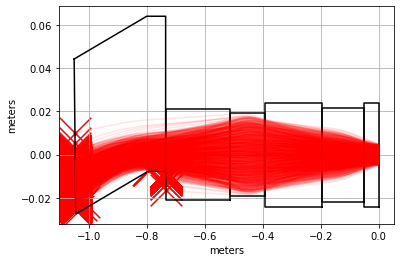

(271.36403180203723, 254.4462491660577)

In [2]:
#trace through injector
# %matplotlib tk
# %matplotlib inline
fastMode=False
h=5e-6

optimizer.generate_Swarms()
swarm=optimizer.swarmInjectorInitial
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=True,
    fastMode=fastMode, copySwarm=True,
    accelerated=True,energyCorrection=False,stepsBetweenLogging=4)
swarmEnd = optimizer.move_Survived_Particles_From_Injector_Combiner_To_Origin(swarmInjectorTraced, copyParticles=True)
# print(swarmEnd.num_Particles())
swarmRingInitial = optimizer.swarmTracerRing.move_Swarm_To_Combiner_Output(swarmEnd, copySwarm=False,scoot=True)
optimizer.latticeInjector.show_Lattice(swarm=swarmInjectorTraced,trueAspectRatio=False,showTraceLines=True,traceLineAlpha=.1,showMarkers=True,finalCoords=True,showRelativeSurvival=False) #careful about which swarm
optimizer.swarmInjectorInitial.num_Particles(weighted=True),swarmRingInitial.num_Particles(weighted=True)

In [3]:
#trace through lattice
%matplotlib inline
import multiprocess as mp
def percentFluxMult(T,energyCons=True,parallel=False):
    fastMode=True
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=parallel,
                            fastMode=fastMode, accelerated=True, copySwarm=True,energyCorrection=energyCons,stepsBetweenLogging=4)
    # PTL_Ring.show_Lattice(swarm=swarmTraced,showMarkers=True,showTraceLines=True,traceLineAlpha=.5)
    # print(swarmTraced.lattice_Flux())
    # print(sum([p.probability*p.revolutions for p in swarmTraced]))
    survivalFrac=swarmTraced.num_Particles(weighted=True)/optimizer.swarmInjectorInitial.num_Particles(weighted=True)
    maxFluxMult=T*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
    swarmFluxMult=swarmTraced.weighted_Flux_Multiplication()
    return 1e2*survivalFrac*swarmFluxMult/maxFluxMult

# TArr=np.logspace(np.log10(.05),np.log10(10),10)
# results=tool_Parallel_Process(percentFluxMult,TArr,resultsAsArray=True,processes=1)
print(percentFluxMult(10,energyCons=True,parallel=True),percentFluxMult(10,energyCons=False,parallel=True)) #23.11714456552582 27.85058846209365

27.77204588301954 29.309433965213557


In [ ]:
%matplotlib inline
resultsFluxMult=1e-2*results*TArr*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
# resultsFluxMult=resultsFluxMult/(results*1e-2)
# plt.figure(figsize=(13,8))
plt.plot(TArr,results,linewidth=1.0)
plt.plot(TArr,results,c='r',marker='o',linewidth=0.0)
plt.grid()
plt.xlabel('Storage time, seconds')
plt.ylabel('Efficiency, %')
plt.savefig('image_HexapoleCombinerSurvival3.jpg',dpi=100)
plt.show()

# work in progress

In [2]:
swarm=optimizer.swarmTracerRing.initalize_PseudoRandom_Swarm_In_Phase_Space(1e-3,1.0,1.0,10,sameSeed=42)
swarmTraced=optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarm,5e-6,.1,fastMode=False)

In [3]:
%matplotlib tk
swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=False)

In [44]:
def percentFluxMult_FUll(T,energyCons=True,parallel=False):
    swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
        optimizer.swarmInjectorInitial
        , h, 1.0, parallel=parallel,
        fastMode=True, copySwarm=True,
        accelerated=True,energyCorrection=energyCons,stepsBetweenLogging=4)
    swarmEnd = optimizer.move_Survived_Particles_From_Injector_Combiner_To_Origin(swarmInjectorTraced, copyParticles=True)
    # print(swarmEnd.num_Particles())
    swarmRingInitial = optimizer.swarmTracerRing.move_Swarm_To_Combiner_Output(swarmEnd, copySwarm=False,scoot=True)

    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=False,
                                                                        fastMode=True, accelerated=True, copySwarm=True,energyCorrection=energyCons,stepsBetweenLogging=4)
    survivalFrac=swarmTraced.num_Particles(weighted=True)/optimizer.swarmInjectorInitial.num_Particles(weighted=True)
    maxFluxMult=T*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
    swarmFluxMult=swarmTraced.weighted_Flux_Multiplication()
    return 1e2*survivalFrac*swarmFluxMult/maxFluxMult

In [64]:
lens1,lens2=optimizer.latticeRing.elList[0],optimizer.latticeRing.elList[6]
xArr=np.linspace(.75,1.25,10)
coords=np.array(list(itertools.product(xArr,xArr)))
def get_Survival(coord):
    lens1.set_fieldFact(coord[0])
    lens2.set_fieldFact(coord[1])
    return percentFluxMult_FUll(5,parallel=False)
# vals=np.array([get_Survival(coord) for coord in coords])
vals=tool_Parallel_Process(get_Survival,coords,resultsAsArray=True)

36.67237478377902

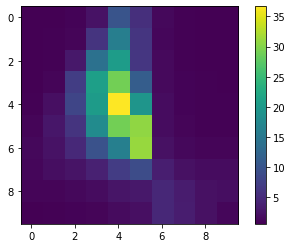

In [66]:
image=vals.reshape((10,10))
plt.imshow(image)
plt.colorbar()
np.column_stack((coords,vals))
vals.max()

In [72]:
combinerInjector,combinerRing=optimizer.latticeInjector.elList[5],optimizer.latticeRing.elList[2]
xArr=np.linspace(.75,1.25,11)
# coords=np.array(list(itertools.product(xArr,xArr)))
def get_Survival(x):
    combinerRing.update_Field_Fact(x)
    combinerInjector.update_Field_Fact(-x)
    # return percentFluxMult_FUll(1.0,parallel=False)

# vals=tool_Parallel_Process(get_Survival,xArr,resultsAsArray=True)
# get_Survival(1)

(1, -1)

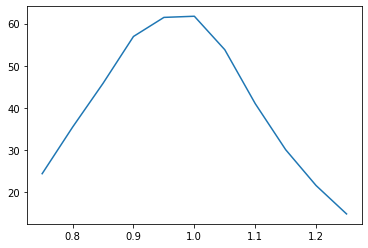

In [52]:
plt.plot(xArr,vals)
plt.show()

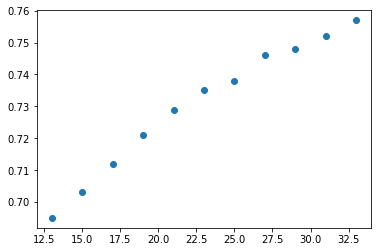

In [4]:
x=[13,15,17,19,21,23,25,27,29,31,33]
y=[.695,.703,.712,.721,.729,.735,.738,.746,.748,.752,.757]
plt.scatter(x,y)

In [5]:
data=np.array([[[-2.76350002e-01,  2.71797557e-02, -1.53445954e-04],
        [ 1.08973054e-01,  1.67795266e-02,  2.97648476e-03]],

       [[-2.93192628e-01,  2.93025474e-02, -1.26842806e-05],
        [ 9.56542066e-02,  1.56753524e-02,  2.84326475e-03]],

       [[-2.89349288e-01,  2.88924619e-02, -1.14371992e-04],
        [ 9.96669774e-02,  1.59533799e-02,  2.87517981e-03]],

       [[-2.93217079e-01,  2.93080827e-02, -1.83967508e-05],
        [ 9.56499424e-02,  1.56721332e-02,  2.84383546e-03]],

       [[-2.92009497e-01,  2.92076816e-02, -8.49554352e-05],
        [ 9.71206147e-02,  1.57621620e-02,  2.85767879e-03]],

       [[-2.93228700e-01,  2.93121082e-02, -1.99750279e-05],
        [ 9.56465702e-02,  1.56701920e-02,  2.84375132e-03]],

       [[-2.92876139e-01,  2.92956762e-02, -4.97649209e-05],
        [ 9.61433012e-02,  1.56988104e-02,  2.85015350e-03]],

       [[-2.93230450e-01,  2.93124239e-02, -1.99980983e-05],
        [ 9.56453982e-02,  1.56697982e-02,  2.84356537e-03]],

       [[-2.93051661e-01,  2.93006249e-02, -3.30990807e-05],
        [ 9.58559120e-02,  1.56872502e-02,  2.84728372e-03]],

       [[-2.93228932e-01,  2.93122755e-02, -2.03845653e-05],
        [ 9.56472357e-02,  1.56702519e-02,  2.84384548e-03]],

       [[-2.93166296e-01,  2.93065753e-02, -2.19562642e-05],
        [ 9.56875662e-02,  1.56796695e-02,  2.84543895e-03]],

       [[-2.93213745e-01,  2.93094351e-02, -1.94339726e-05],
        [ 9.56509107e-02,  1.56718316e-02,  2.84405726e-03]],

       [[-2.93180909e-01,  2.93066760e-02, -2.07297763e-05],
        [ 9.56654297e-02,  1.56783548e-02,  2.84491113e-03]],

       [[-2.93212918e-01,  2.93099060e-02, -2.04213317e-05],
        [ 9.56518643e-02,  1.56720683e-02,  2.84420216e-03]],

       [[-2.93181684e-01,  2.93062163e-02, -2.09468226e-05],
        [ 9.56645597e-02,  1.56777942e-02,  2.84479858e-03]],

       [[-2.93211989e-01,  2.93101116e-02, -2.05862014e-05],
        [ 9.56530362e-02,  1.56725631e-02,  2.84441174e-03]],

       [[-2.93180963e-01,  2.93056051e-02, -2.10903200e-05],
        [ 9.56638513e-02,  1.56775886e-02,  2.84469475e-03]],

       [[-2.93197457e-01,  2.93062465e-02, -2.06824352e-05],
        [ 9.56560305e-02,  1.56740070e-02,  2.84463606e-03]],

       [[-2.93169116e-01,  2.93017689e-02, -2.07683820e-05],
        [ 9.56653200e-02,  1.56784722e-02,  2.84465335e-03]],

       [[-2.93196327e-01,  2.93065834e-02, -2.04998396e-05],
        [ 9.56571558e-02,  1.56744751e-02,  2.84484368e-03]],

       [[-2.93182282e-01,  2.93051756e-02, -2.12854396e-05],
        [ 9.56627347e-02,  1.56771343e-02,  2.84463334e-03]],

       [[-2.93195944e-01,  2.93067349e-02, -2.05020700e-05],
        [ 9.56582173e-02,  1.56748001e-02,  2.84482490e-03]],

       [[-2.93170390e-01,  2.93014664e-02, -2.11634257e-05],
        [ 9.56647493e-02,  1.56782644e-02,  2.84459754e-03]],

       [[-2.93195129e-01,  2.93066833e-02, -2.05531689e-05],
        [ 9.56589630e-02,  1.56749901e-02,  2.84472843e-03]],

       [[-2.93159463e-01,  2.92979617e-02, -2.13373443e-05],
        [ 9.56656619e-02,  1.56791719e-02,  2.84456308e-03]],

       [[-2.93207671e-01,  2.93104578e-02, -2.07970302e-05],
        [ 9.56575715e-02,  1.56738853e-02,  2.84462927e-03]]])

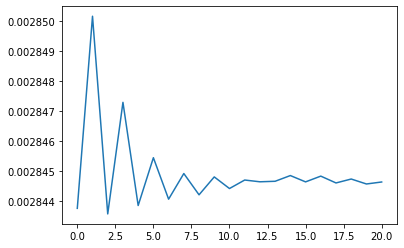

In [19]:
plt.plot(data[:,1,2][5:])
plt.show()

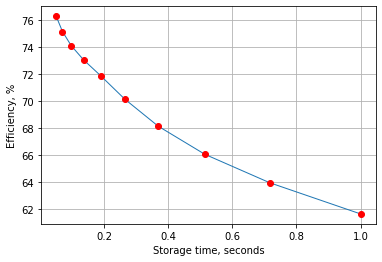

In [37]:
%matplotlib inline
resultsFluxMult=1e-2*results*TArr*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
# resultsFluxMult=resultsFluxMult/(results*1e-2)
# plt.figure(figsize=(13,8))
plt.plot(TArr,results,linewidth=1.0)
plt.plot(TArr,results,c='r',marker='o',linewidth=0.0)
plt.grid()
plt.xlabel('Storage time, seconds')
plt.ylabel('Efficiency, %')
plt.savefig('image_HexapoleCombinerSurvival3.jpg',dpi=100)
plt.show()

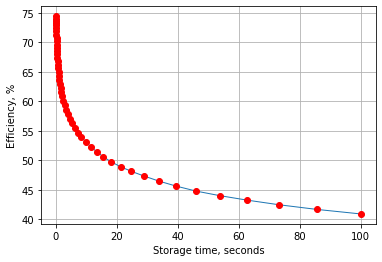

In [17]:
%matplotlib inline
resultsFluxMult=1e-2*results*TArr*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
# resultsFluxMult=resultsFluxMult/(results*1e-2)
# plt.figure(figsize=(13,8))
plt.plot(TArr,results,linewidth=1.0)
plt.plot(TArr,results,c='r',marker='o',linewidth=0.0)
plt.grid()
plt.xlabel('Storage time, seconds')
plt.ylabel('Efficiency, %')
plt.savefig('image_HexapoleCombinerSurvival3.jpg',dpi=100)
plt.show()

0.5300709840288027

In [15]:
flux=results[:,0]
fluxMax=results[:,1]
vacuumLine=(TArr*flux[0]/TArr[0])
maxLIne=(TArr*fluxMax[0]/TArr[0])
plt.scatter(TArr,flux/fluxMax)
plt.show()
plt.scatter(TArr,flux,label='simulation results')
plt.plot(TArr,vacuumLine,label='vacuum limited injected',c='r')
plt.plot(TArr,maxLIne,label='vacuum limited, ideal loading',c='g')
plt.ylabel('Flux multiplication')
plt.xlabel('Time, seconds')
plt.grid()
plt.legend()
plt.show()
flux[-1],fluxMax[0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# look at energy conservation

In [94]:
TMaxE_Test=10.0
swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, TMaxE_Test, parallel=True,
                                                                    fastMode=True, accelerated=True, copySwarm=True,energyCorrection=False)

In [95]:
particleEnergyTestList=[]
for particle in swarmTraced:
    if particle.clipped==False:
        particleFresh=Particle(qi=particle.qi,pi=particle.pi)
        particleEnergyTestList.append(particleFresh)
    if len(particleEnergyTestList)>=5:
        break
swarmE_Test=Swarm()
swarmE_Test.particles=particleEnergyTestList

12.062384128570557


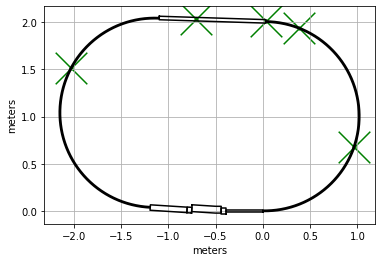

In [97]:
t=time.time()
swarmE_TestTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmE_Test, optimizer.h, TMaxE_Test, parallel=True,
                                    fastMode=False, accelerated=True, copySwarm=True,energyCorrection=False,stepsBetweenLogging=8)
print(time.time()-t)
PTL_Ring.show_Lattice(swarm=swarmE_TestTraced,showMarkers=True)

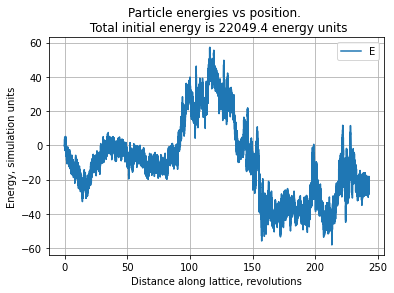

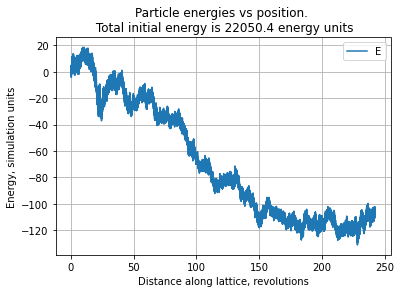

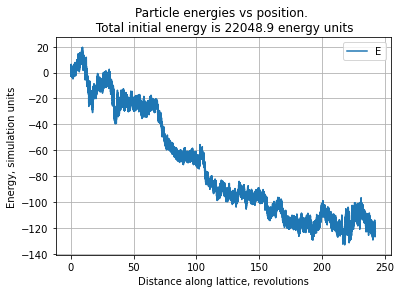

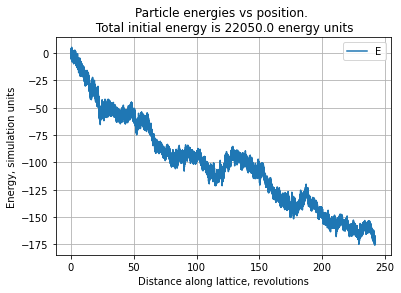

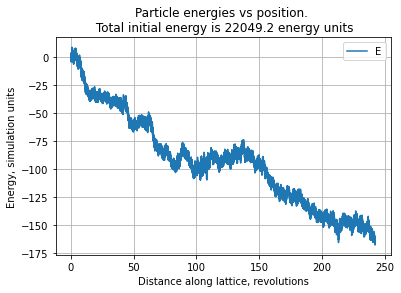

In [98]:
%matplotlib inline
for particle in swarmE_TestTraced:
    particle.plot_Energies(showOnlyTotalEnergy=True)
# swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=True)
# p0Arr=swarmTraced.particles[0].p0Arr
# plt.plot(p0Arr)
# plt.show()

# make some nice plots

### Nice plots of injection

In [3]:
#trace through injector
# %matplotlib tk
# %matplotlib inline
fastMode=False
h=5e-6
optimizer.generate_Swarms()
swarm=optimizer.swarmInjectorInitial
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=True,
    fastMode=fastMode, copySwarm=True,
    accelerated=True,energyCorrection=False,stepsBetweenLogging=4)

for i,particle in enumerate(swarmInjectorTraced):
    particle.i=i
swarmEnd = optimizer.move_Survived_Particles_From_Injector_Combiner_To_Origin(swarmInjectorTraced, copyParticles=True)
for particle1 in swarmEnd:
    for particle2 in swarmInjectorTraced:
        if particle1.i==particle2.i:
            particle2.clipped=False

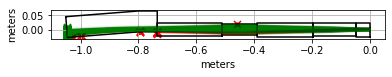

In [5]:
optimizer.latticeInjector.show_Lattice(swarm=swarmInjectorTraced,trueAspectRatio=True,showTraceLines=True,traceLineAlpha=.02,showMarkers=True,finalCoords=True,showRelativeSurvival=False,defaultMarkerSize=50,saveTitle='injectorImage')

In [61]:
survival=swarmEnd.num_Particles()/swarmInjectorTraced.num_Particles()
survival

0.924